In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    #rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

In [4]:
data = pd.read_csv('Combined_all_3rd_fit.csv', encoding='cp1252')
print(data.columns.values)

['Name' 'Coef_a' 'Coef_b' 'Coef_c' 'Coef_d' 'A_site' 'B_site' 'X_site'
 'Spacegroup' 'Ehull' 'BulkModulus' 'Energy' 'ZPE' 's_A' 's_B' 's_X'
 'density' 'mean_A2B' 'mean_A2X' 'mean_B2X' 'mean_X2X' 'std_A2B' 'std_A2X'
 'std_B2X' 'std_X2X' 'E_coh' 'TF' 'OF' 'A_Z' 'B_Z' 'X_Z' 'A_M' 'B_M' 'X_M'
 'A_G' 'B_G' 'X_G' 'A_IEI' 'B_IEI' 'X_IEI' 'A_IEII' 'B_IEII' 'X_IEII'
 'A_EA' 'B_EA' 'X_EA' 'A_ChiP' 'B_ChiP' 'X_ChiP' 'A_ChiA' 'X_ChiA'
 'A_Rvdw' 'B_Rvdw' 'X_Rvdw' 'A_Rc' 'B_Rc' 'X_Rc' 'A_Ra' 'B_Ra' 'X_Ra'
 'A_MP' 'B_MP' 'X_MP' 'A_BP' 'B_BP' 'X_BP' 'A_Rho' 'B_Rho' 'A_MV' 'B_MV'
 'X_MV' 'A_Hf' 'B_Hf' 'X_Hf' 'A_Hv' 'B_Hv' 'X_Hv' 'A_Kappa' 'B_Kappa'
 'X_Kappa' 'A_CvM' 'B_CvM' 'X_CvM' 'A_B' 'B_B' 'X_B' 'A_MendeleevNo'
 'B_MendeleevNo' 'X_MendeleevNo']


In [5]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup','BulkModulus',
           'Ehull','Energy','ZPE','Coef_b', 'Coef_a', 'Coef_d'], axis=1, inplace = True)
target = 'Coef_c'

In [6]:
data.fillna(0, inplace= True)
d=data.copy()
columns = list(d.columns.values)

# Standard Scaling

In [7]:
data_std=d.copy()
scalerSTD=StandardScaler()
scalerSTD.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_std= scalerSTD.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [8]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


In [9]:
#data_std.to_csv("scaled_non_correlated.csv")

### Using CV technique

RF
R2:  0.8893442410136421
RMSE:  0.3326496039173321
---------------------------------------
GB
R2:  0.8935648484104816
RMSE:  0.326244006212403
---------------------------------------
RR
R2:  0.6462568855945379
RMSE:  0.5947630741778294
---------------------------------------
LASSO
R2:  0.9285839665291872
RMSE:  0.2672377845118703
---------------------------------------
gpr1
R2:  0.8913993131357336
RMSE:  0.329546183203912
---------------------------------------
gpr2
R2:  0.9345230480284559
RMSE:  0.2558846458299991
---------------------------------------
gpr3
R2:  0.9187191005508805
RMSE:  0.28509805234185587
---------------------------------------
gpr4
R2:  0.9318310685595018
RMSE:  0.2610918065365096
---------------------------------------
[0.8893442410136421, 0.8935648484104816, 0.6462568855945379, 0.9285839665291872, 0.8913993131357336, 0.9345230480284559, 0.9187191005508805, 0.9318310685595018]


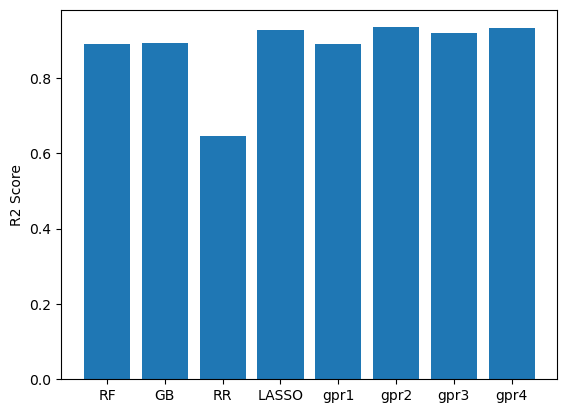

In [10]:
run_models()

## Feature selection


In [11]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  342.561672
2        s_X  224.085608
17       X_Z  200.923811
7   mean_X2X  144.584059
35      X_Ra  143.785064
5   mean_A2X   96.188443
1        s_B   50.869033
33    A_Rvdw   44.335733
28      X_EA   43.047947
12     E_coh   42.583723
0        s_A   35.416986
45   X_Kappa   32.559689
32    X_ChiA   30.952649
20     A_IEI   27.313322
22     X_IEI   20.065186
41      X_MV   19.114335
44   B_Kappa   19.043771
9    std_A2X   16.241729
31    A_ChiA   14.678545
27      B_EA   14.477919
15       A_Z   12.628214
29    A_ChiP   11.969555
37      A_BP   11.579900
10   std_B2X   10.809447
16       B_Z    9.440231
25    X_IEII    9.352237
36      B_MP    9.089462
43   A_Kappa    8.458841
46     A_CvM    8.388239
42      B_Hf    8.046263


In [12]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'mean_X2X', 'X_Ra', 'mean_A2X', 's_B',
       'A_Rvdw', 'X_EA', 'E_coh', 's_A', 'X_Kappa', 'X_ChiA', 'A_IEI',
       'X_IEI', 'X_MV', 'B_Kappa', 'std_A2X', 'A_ChiA', 'B_EA', 'A_Z',
       'A_ChiP', 'A_BP', 'std_B2X', 'B_Z', 'X_IEII', 'B_MP', 'A_Kappa',
       'A_CvM', 'B_Hf', 'B_ChiP', 'OF', 'A_B', 'A_EA', 'B_Rho', 'B_IEI',
       'B_MV', 'B_Ra', 'density', 'TF'], dtype=object)

In [13]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9018293649522207
RMSE:  0.3133219351526148
---------------------------------------
GB
R2:  0.8898448488306135
RMSE:  0.33189629580546165
---------------------------------------
RR
R2:  0.8097239991597116
RMSE:  0.4362063741399114
---------------------------------------
LASSO
R2:  0.9337739969853169
RMSE:  0.25734413343747126
---------------------------------------
gpr1
R2:  0.9286531577872075
RMSE:  0.26710829678763737
---------------------------------------
gpr2
R2:  0.9376201112361945
RMSE:  0.24975966200290534
---------------------------------------
gpr3
R2:  0.9269550592118785
RMSE:  0.27026827558579924
---------------------------------------
gpr4
R2:  0.9400765743312406
RMSE:  0.24479261767618615
---------------------------------------
[0.9018293649522207, 0.8898448488306135, 0.8097239991597116, 0.9337739969853169, 0.9286531577872075, 0.9376201112361945, 0.9269550592118785, 0.9400765743312406]


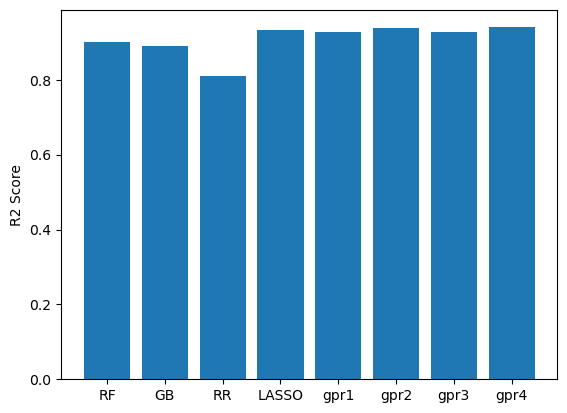

In [14]:
run_models()

In [15]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'mean_X2X', 'X_Ra', 'mean_A2X', 's_B',
       'A_Rvdw', 'X_EA', 'E_coh', 's_A', 'X_Kappa', 'X_ChiA', 'A_IEI',
       'X_IEI', 'X_MV', 'B_Kappa', 'std_A2X', 'A_ChiA', 'B_EA', 'A_Z',
       'A_ChiP', 'A_BP', 'std_B2X', 'B_Z', 'X_IEII', 'B_MP', 'A_Kappa',
       'A_CvM', 'B_Hf'], dtype=object)

In [16]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
t30_columns = ['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'X_IEII', 'B_Hf', 'A_ChiP', 'B_MP', 'A_BP', 'std_B2X', 'A_Z',
       'X_Kappa', 'A_EA', 'B_Ra', 'OF', 'A_CvM', 'B_Z', 'A_Kappa',
       'B_Kappa', 'X_ChiA']
data_save=data_std[t30_columns]
#data_save.to_csv("scaled_top_30.csv")

RF
R2:  0.9098223749331507
RMSE:  0.30029589585415467
---------------------------------------
GB
R2:  0.898248603397254
RMSE:  0.3189849472980599
---------------------------------------
RR
R2:  0.8437643637044561
RMSE:  0.3952665382947864
---------------------------------------
LASSO
R2:  0.919322121936432
RMSE:  0.28403851510590594
---------------------------------------
gpr1
R2:  0.9085666317437125
RMSE:  0.3023795103116073
---------------------------------------
gpr2
R2:  0.9331337413708521
RMSE:  0.2585851090630468
---------------------------------------
gpr3
R2:  0.9278656326995834
RMSE:  0.2685784192752958
---------------------------------------
gpr4
R2:  0.9371288412189772
RMSE:  0.25074121875157024
---------------------------------------
[0.9098223749331507, 0.898248603397254, 0.8437643637044561, 0.919322121936432, 0.9085666317437125, 0.9331337413708521, 0.9278656326995834, 0.9371288412189772]


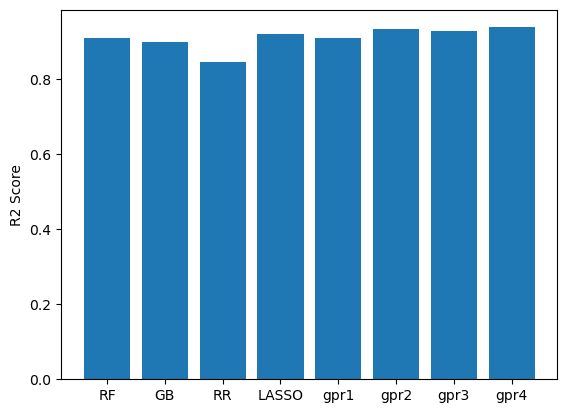

In [17]:
run_models()

In [18]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'mean_X2X', 'X_Ra', 'mean_A2X', 's_B',
       'A_Rvdw', 'X_EA', 'E_coh', 's_A', 'X_Kappa', 'X_ChiA', 'A_IEI',
       'X_IEI', 'X_MV', 'B_Kappa', 'std_A2X', 'A_ChiA', 'B_EA'],
      dtype=object)

In [19]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.867167809097972
RMSE:  0.3644615081212666
---------------------------------------
GB
R2:  0.8734328915607379
RMSE:  0.35576271367199525
---------------------------------------
RR
R2:  0.8895005515133055
RMSE:  0.3324145732164799
---------------------------------------
LASSO
R2:  0.9070368276136155
RMSE:  0.3048986264094749
---------------------------------------
gpr1
R2:  0.8976001748381128
RMSE:  0.3199997268153322
---------------------------------------
gpr2
R2:  0.9181765697721329
RMSE:  0.28604795092408386
---------------------------------------
gpr3
R2:  0.9195568863652028
RMSE:  0.2836249524192066
---------------------------------------
gpr4
R2:  0.9222785150601354
RMSE:  0.2787857330278303
---------------------------------------
[0.867167809097972, 0.8734328915607379, 0.8895005515133055, 0.9070368276136155, 0.8976001748381128, 0.9181765697721329, 0.9195568863652028, 0.9222785150601354]


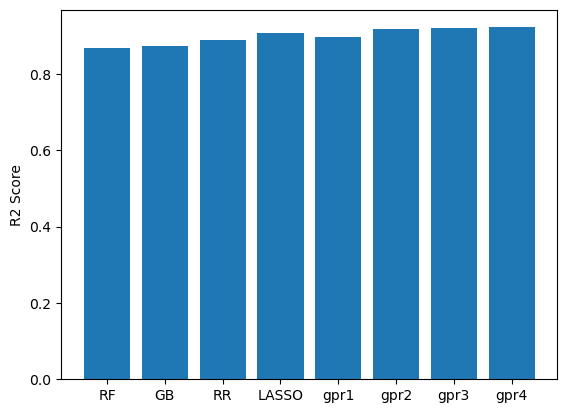

In [20]:
run_models()

In [21]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'mean_X2X', 'X_Ra', 'mean_A2X', 's_B',
       'A_Rvdw', 'X_EA', 'E_coh'], dtype=object)

In [22]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8814612960967867
RMSE:  0.3442945017034303
---------------------------------------
GB
R2:  0.858285943661067
RMSE:  0.376449274589463
---------------------------------------
RR
R2:  0.784404088858874
RMSE:  0.4643230676383912
---------------------------------------
LASSO
R2:  0.8190522653702434
RMSE:  0.4253795183477415
---------------------------------------
gpr1
R2:  0.8060183544278696
RMSE:  0.44043347462713406
---------------------------------------
gpr2
R2:  0.8401842615602308
RMSE:  0.3997696066983696
---------------------------------------
gpr3
R2:  0.8616952422467384
RMSE:  0.3718934763521156
---------------------------------------
gpr4
R2:  0.8484102854293706
RMSE:  0.38934523827912604
---------------------------------------
[0.8814612960967867, 0.858285943661067, 0.784404088858874, 0.8190522653702434, 0.8060183544278696, 0.8401842615602308, 0.8616952422467384, 0.8484102854293706]


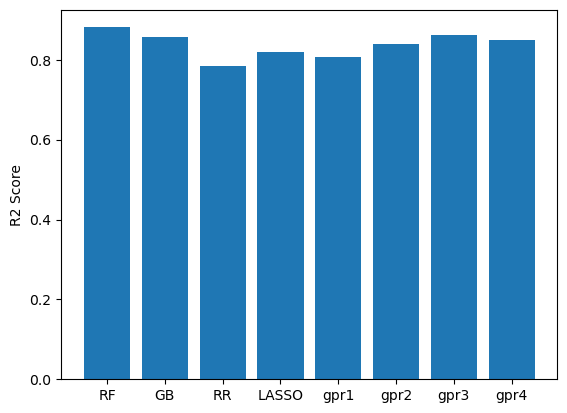

In [23]:
run_models()

# Min-Max scaling

In [24]:
data_std=d.copy()
scalerMM=MinMaxScaler()
scalerMM.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_mm= scalerMM.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [25]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)
#data_std.to_csv('Coef_a_scaled_non_corr_all.csv',index=False)

(80, 51)


### Using CV technique

RF
R2:  0.893252675799644
RMSE:  0.07918338433105007
---------------------------------------
GB
R2:  0.8908372276166661
RMSE:  0.08007424258303364
---------------------------------------
RR
R2:  0.8883775727749645
RMSE:  0.08097133356359146
---------------------------------------
LASSO
R2:  0.6058142953169071
RMSE:  0.15216192579559554
---------------------------------------
gpr1
R2:  0.8614727356019577
RMSE:  0.09020345866092419
---------------------------------------
gpr2
R2:  -0.07060212132074595
RMSE:  0.25076655330241954
---------------------------------------
gpr3
R2:  0.9371981859215509
RMSE:  0.06073536634301369
---------------------------------------
gpr4
R2:  0.9307345179070402
RMSE:  0.06378432906487999
---------------------------------------
[0.893252675799644, 0.8908372276166661, 0.8883775727749645, 0.6058142953169071, 0.8614727356019577, -0.07060212132074595, 0.9371981859215509, 0.9307345179070402]


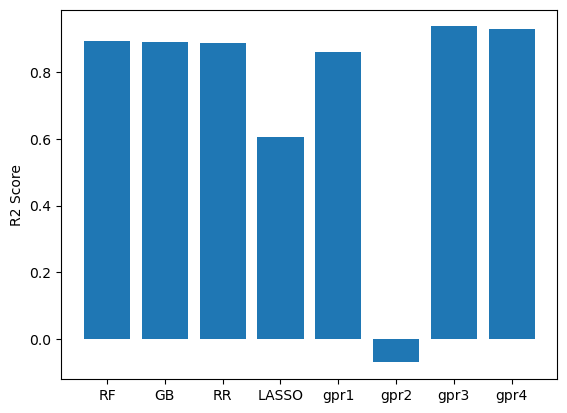

In [26]:
run_models()

## Feature selection


In [27]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  342.561672
2        s_X  224.085608
17       X_Z  200.923811
7   mean_X2X  144.584059
35      X_Ra  143.785064
5   mean_A2X   96.188443
1        s_B   50.869033
33    A_Rvdw   44.335733
28      X_EA   43.047947
12     E_coh   42.583723
0        s_A   35.416986
45   X_Kappa   32.559689
32    X_ChiA   30.952649
20     A_IEI   27.313322
22     X_IEI   20.065186
41      X_MV   19.114335
44   B_Kappa   19.043771
9    std_A2X   16.241729
31    A_ChiA   14.678545
27      B_EA   14.477919
15       A_Z   12.628214
29    A_ChiP   11.969555
37      A_BP   11.579900
10   std_B2X   10.809447
16       B_Z    9.440231
25    X_IEII    9.352237
36      B_MP    9.089462
43   A_Kappa    8.458841
46     A_CvM    8.388239
42      B_Hf    8.046263


In [28]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'mean_X2X', 'X_Ra', 'mean_A2X', 's_B',
       'A_Rvdw', 'X_EA', 'E_coh', 's_A', 'X_Kappa', 'X_ChiA', 'A_IEI',
       'X_IEI', 'X_MV', 'B_Kappa', 'std_A2X', 'A_ChiA', 'B_EA', 'A_Z',
       'A_ChiP', 'A_BP', 'std_B2X', 'B_Z', 'X_IEII', 'B_MP', 'A_Kappa',
       'A_CvM', 'B_Hf', 'B_ChiP', 'OF', 'A_B', 'A_EA', 'B_Rho', 'B_IEI',
       'B_MV', 'B_Ra', 'density', 'TF'], dtype=object)

In [29]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8788014310602293
RMSE:  0.08437315845211242
---------------------------------------
GB
R2:  0.8802268560562533
RMSE:  0.08387553160731802
---------------------------------------
RR
R2:  0.937374669395016
RMSE:  0.060649968098052
---------------------------------------
LASSO
R2:  0.6058004039972755
RMSE:  0.15216460690668093
---------------------------------------
gpr1
R2:  0.8674142157016702
RMSE:  0.08824783142587048
---------------------------------------
gpr2
R2:  -0.07060214582860525
RMSE:  0.2507665561726508
---------------------------------------
gpr3
R2:  0.9459206405072543
RMSE:  0.056360044923729785
---------------------------------------
gpr4
R2:  0.9352552070400751
RMSE:  0.061667733114057405
---------------------------------------
[0.8788014310602293, 0.8802268560562533, 0.937374669395016, 0.6058004039972755, 0.8674142157016702, -0.07060214582860525, 0.9459206405072543, 0.9352552070400751]


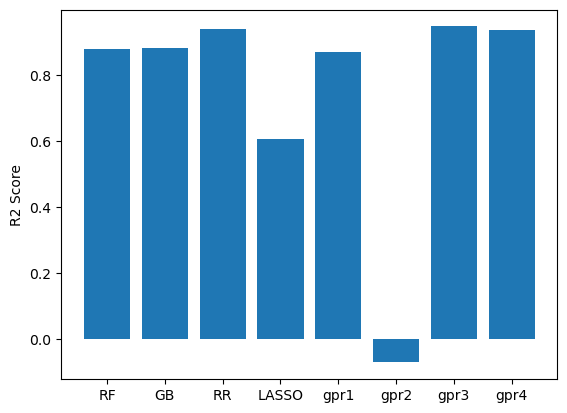

In [30]:
run_models()

In [31]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'mean_X2X', 'X_Ra', 'mean_A2X', 's_B',
       'A_Rvdw', 'X_EA', 'E_coh', 's_A', 'X_Kappa', 'X_ChiA', 'A_IEI',
       'X_IEI', 'X_MV', 'B_Kappa', 'std_A2X', 'A_ChiA', 'B_EA', 'A_Z',
       'A_ChiP', 'A_BP', 'std_B2X', 'B_Z', 'X_IEII', 'B_MP', 'A_Kappa',
       'A_CvM', 'B_Hf'], dtype=object)

In [32]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8895485595582715
RMSE:  0.0805454946573523
---------------------------------------
GB
R2:  0.8760893287933667
RMSE:  0.08531195920616763
---------------------------------------
RR
R2:  0.9002233456928256
RMSE:  0.07655437753101167
---------------------------------------
LASSO
R2:  0.6058004039972755
RMSE:  0.15216460690668093
---------------------------------------
gpr1
R2:  0.9042145282290542
RMSE:  0.07500761944986291
---------------------------------------
gpr2
R2:  -0.07060228897427678
RMSE:  0.2507665729371165
---------------------------------------
gpr3
R2:  0.9381562543646181
RMSE:  0.060270313932290626
---------------------------------------
gpr4
R2:  0.9290219005509808
RMSE:  0.06456806092688494
---------------------------------------
[0.8895485595582715, 0.8760893287933667, 0.9002233456928256, 0.6058004039972755, 0.9042145282290542, -0.07060228897427678, 0.9381562543646181, 0.9290219005509808]


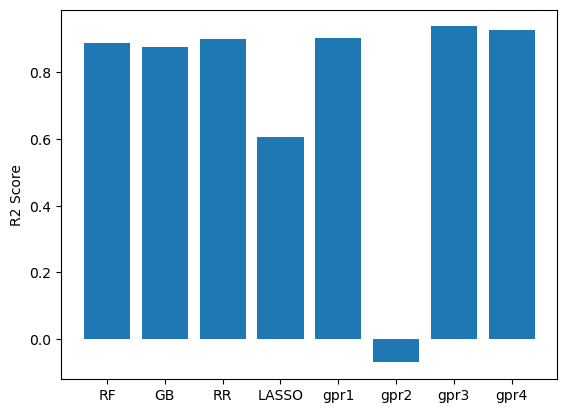

In [33]:
run_models()

In [34]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'mean_X2X', 'X_Ra', 'mean_A2X', 's_B',
       'A_Rvdw', 'X_EA', 'E_coh', 's_A', 'X_Kappa', 'X_ChiA', 'A_IEI',
       'X_IEI', 'X_MV', 'B_Kappa', 'std_A2X', 'A_ChiA', 'B_EA'],
      dtype=object)

In [35]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8878987811201015
RMSE:  0.08114480638408379
---------------------------------------
GB
R2:  0.9064424974573331
RMSE:  0.07413014865467256
---------------------------------------
RR
R2:  0.8939422935629141
RMSE:  0.07892719642283916
---------------------------------------
LASSO
R2:  0.6058004039972755
RMSE:  0.15216460690668093
---------------------------------------
gpr1
R2:  0.8990282543017735
RMSE:  0.07701148420132525
---------------------------------------
gpr2
R2:  -0.07060214729733127
RMSE:  0.2507665563446603
---------------------------------------
gpr3
R2:  0.92917727535151
RMSE:  0.06449735076443161
---------------------------------------
gpr4
R2:  0.9173477771438276
RMSE:  0.06967593895521541
---------------------------------------
[0.8878987811201015, 0.9064424974573331, 0.8939422935629141, 0.6058004039972755, 0.8990282543017735, -0.07060214729733127, 0.92917727535151, 0.9173477771438276]


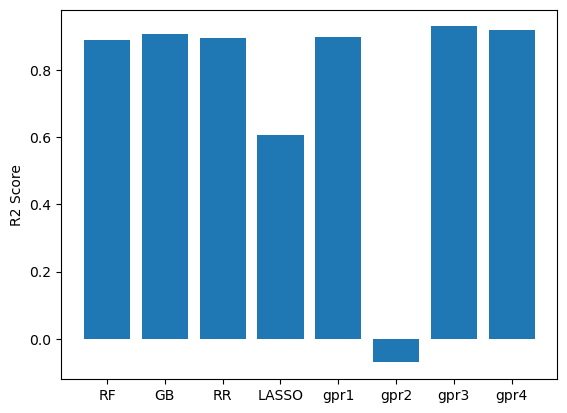

In [36]:
run_models()

In [37]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'mean_X2X', 'X_Ra', 'mean_A2X', 's_B',
       'A_Rvdw', 'X_EA', 'E_coh'], dtype=object)

In [38]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8635875189201085
RMSE:  0.0895122790986837
---------------------------------------
GB
R2:  0.8750216195830856
RMSE:  0.08567872739008393
---------------------------------------
RR
R2:  0.7906545741604285
RMSE:  0.1108887017749346
---------------------------------------
LASSO
R2:  0.6058003872570061
RMSE:  0.15216461013762853
---------------------------------------
gpr1
R2:  0.8242004416031288
RMSE:  0.10161655113767519
---------------------------------------
gpr2
R2:  -0.07060218082420477
RMSE:  0.25076656027115085
---------------------------------------
gpr3
R2:  0.8543692540388809
RMSE:  0.09248729932766621
---------------------------------------
gpr4
R2:  0.8417968204737112
RMSE:  0.09639692152998519
---------------------------------------
[0.8635875189201085, 0.8750216195830856, 0.7906545741604285, 0.6058003872570061, 0.8242004416031288, -0.07060218082420477, 0.8543692540388809, 0.8417968204737112]


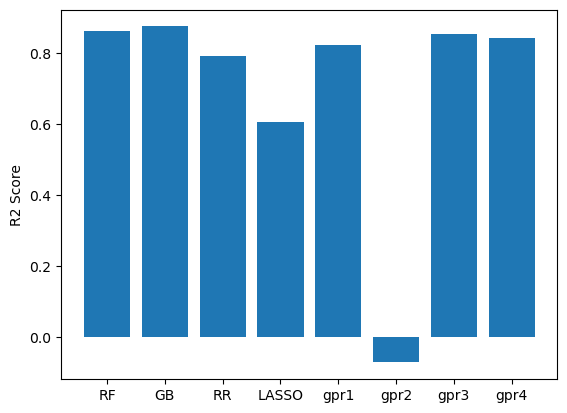

In [39]:
run_models()